In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ifigotin/imagenetmini-1000")

print("Path to dataset files:",path)

100%|██████████| 3.92G/3.92G [01:06<00:00, 63.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ifigotin/imagenetmini-1000/versions/1


In [2]:
!pip install torch torchvision torchaudio  # Install PyTorch and related packages
!pip install clip-by-openai               # Install the CLIP model from OpenAI
!pip install faiss-cpu                   # Install FAISS (CPU version)
!pip install numpy                       # Install NumPy
!pip install Pillow                      # Install Pillow (PIL fork)
!pip install scikit-learn                # Install scikit-learn for normalization
!pip install tqdm

INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1.1.3, clip-by-openai==0.1.1.4, clip-by-openai==0.1.1.5, clip-by-openai==1.0.1 and clip-by-openai==1.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    clip-by-openai 1.1 depends on torch<1.7.2 and >=1.7.1
    clip-by-openai 1.0.1 depends on torch<1.7.2 and >=1.7.1
    clip-by-openai 0.1.1.5 depends on torch==1.7.1
    clip-by-openai 0.1.1.4 depends on torch==1.7.1
    clip-by-openai 0.1.1.3 depends on torch==1.7.1
    clip-by-openai 0.1.1.2 depends on torch==1.7.1
    clip-by-openai 0.1.1 depends on torch==1.7.1
    clip-by-opena

In [3]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g7ntaj_u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-g7ntaj_u
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=87126414891ed2c776c83119ea315db3e3d8321b5f07b247b1a0964d176e423b
  Stored in directory: /tmp/pip-ephem-wheel-cache-o872h7b_/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [4]:
import os
import torch
import clip
import faiss
import numpy as np
from PIL import Image
from sklearn.preprocessing import normalize
from pathlib import Path
from tqdm import tqdm

In [7]:
import shutil
from pathlib import Path
import os

# Define dataset path and output directory
dataset_path = "/root/.cache/kagglehub/datasets/ifigotin/imagenetmini-1000/versions/1"
output_dir = "/content/images"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# List image files from the dataset (check for multiple formats if needed)
image_paths = [str(p) for p in Path(dataset_path).rglob('*') if p.suffix.lower() in ['.jpeg', '.jpg', '.png', '.bmp', '.gif', '.tiff']]
 # Adjust file extension if needed

# Count the number of images
num_images = len(image_paths)
print(f"Total number of images found: {num_images}")

# Check if the dataset contains any images
if num_images == 0:
    print("No images found in the specified dataset path. Exiting.")
    exit()

try:
    # Move all images to the output directory
    for img_path in image_paths:
        try:
            # Get the file name and destination path
            img_name = os.path.basename(img_path)
            dest_path = os.path.join(output_dir, img_name)

            # Move the image to the destination directory
            shutil.move(img_path, dest_path)
            print(f"Moved: {img_name} to {output_dir}")
        except Exception as e:
            print(f"Error moving {img_path}: {e}")
            continue

    print(f"All images moved to: {output_dir}")

except Exception as e:
    print(f"Error during moving process: {e}")


Total number of images found: 0
No images found in the specified dataset path. Exiting.
All images moved to: /content/images


In [1]:
import os
import json
import numpy as np
import torch
import clip
from PIL import Image
from tqdm import tqdm
from pathlib import Path

# Initialize device and CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 78.9MiB/s]


In [2]:

# File to store embeddings
EMBEDDINGS_FILE = "image_embeddings.json"

# Load existing embeddings or create a new dictionary
if os.path.exists(EMBEDDINGS_FILE):
    with open(EMBEDDINGS_FILE, "r") as f:
        image_embeddings_dict = json.load(f)
else:
    image_embeddings_dict = {}

# Function to get CLIP embedding for an image
def get_clip_embedding(image_path):
    try:
        # Check if the embedding already exists
        if image_path in image_embeddings_dict:
            return np.array(image_embeddings_dict[image_path])

        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image)
        embedding = image_features.cpu().numpy()

        # Save embedding to the dictionary
        image_embeddings_dict[image_path] = embedding.tolist()
        return embedding
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Create embeddings for all images
def create_embeddings(image_paths):
    print("Generating embeddings for all images...")
    for img_path in tqdm(image_paths, desc="Processing images"):
        get_clip_embedding(img_path)
    # Save embeddings to file
    with open(EMBEDDINGS_FILE, "w") as f:
        json.dump(image_embeddings_dict, f)
    print(f"Embeddings saved to {EMBEDDINGS_FILE}")

# Path to image folder
image_folder = "/content/images"
image_paths = [str(p) for p in Path(image_folder).rglob('*.JPEG')]  # List all JPEG images

# Ensure there are images in the folder
if not image_paths:
    print("No images found in the folder.")
    exit()

# Create embeddings for all images
create_embeddings(image_paths)


Generating embeddings for all images...


Processing images:   0%|          | 32/38668 [00:12<4:11:59,  2.56it/s]


KeyboardInterrupt: 

In [5]:
import json
import numpy as np
import faiss
from sklearn.preprocessing import normalize
import torch
import clip
import shutil

# # Initialize device and CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
# clip_model, _ = clip.load("ViT-B/32", device=device)

# Load embeddings from file
EMBEDDINGS_FILE = "image_embeddings.json"
with open(EMBEDDINGS_FILE, "r") as f:
    image_embeddings_dict = json.load(f)

# Extract image paths and embeddings
image_paths = list(image_embeddings_dict.keys())
image_embeddings = np.array(list(image_embeddings_dict.values())).squeeze()
image_embeddings = normalize(image_embeddings, axis=1)  # Normalize embeddings

# Create FAISS index
dim = image_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dim)  # Using L2 distance for similarity search
faiss_index.add(image_embeddings)  # Add embeddings to FAISS index

# Function to get CLIP embedding for text
def get_text_embedding(query_text):
    text = clip.tokenize([query_text]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text)
    return text_features.cpu().numpy()

# Retrieve images for a given query
def retrieve_images(query_text, k=5):
    query_embedding = get_text_embedding(query_text)
    query_embedding = normalize(query_embedding, axis=1)  # Normalize query embedding
    _, indices = faiss_index.search(query_embedding, k)  # Retrieve k nearest neighbors
    return [image_paths[i] for i in indices[0]]

# Query text and retrieval
# query_text = """
# Create a short video of a sunrise over a calm ocean.
# The sun slowly rises from the horizon, changing the sky's color from dark blue to orange.
# Waves gently ripple across the water as birds fly by in the distance.
# Add some subtle reflections of the sun on the water.
# End the video with the sun fully risen, shining brightly in a clear sky.
# """

query_text = """
Create a short video of a bustling city street at night.
Bright neon signs illuminate the scene, with people walking along the sidewalks and cars passing by.
Street vendors sell food from colorful carts, and the aroma fills the air.
A light drizzle begins, creating reflections of the lights on the wet pavement.
End the video with the rain stopping and the city glowing under a clear starry sky.
"""

# Split the query into sentences
sentences = [sentence.strip() for sentence in query_text.strip().split('.') if sentence]

# Perform retrieval for each sentence
retrieved_images = {}
print(f"Total sentences to process: {len(sentences)}")

for i, sentence in enumerate(sentences):
    print(f"\nProcessing Sentence {i + 1}: {sentence}")
    top_image = retrieve_images(sentence, k=1)  # Retrieve one image for the current sentence
    if top_image:
        retrieved_images[f"Sentence {i + 1}"] = top_image[0]  # Store the top image path
        print(f"Retrieved Image: {top_image[0]}")
    else:
        retrieved_images[f"Sentence {i + 1}"] = "No image retrieved"
        print("No image retrieved for this sentence.")

# Display the retrieved images
print("\nFinal Retrieved Images:")
image_paths = []
for sentence, img_path in retrieved_images.items():
    print(f"{img_path}")
    image_paths.append(img_path)


# Define the destination folder
destination_folder = "extracted_frames"
os.makedirs(destination_folder, exist_ok=True)  # Create the folder if it doesn't exist

# Save retrieved images to the folder
print("\nSaving retrieved images to the folder...")
for sentence, img_path in retrieved_images.items():
    if img_path != "No image retrieved":  # Skip if no image was retrieved for the sentence
        try:
            # Extract the filename from the image path
            filename = os.path.basename(img_path)
            # Define the destination path
            destination_path = os.path.join(destination_folder, filename)
            # Copy the image to the destination folder
            shutil.copy(img_path, destination_path)
            print(f"Saved: {filename} -> {destination_path}")
        except Exception as e:
            print(f"Error saving {img_path}: {e}")
    else:
        print(f"No image to save for {sentence}")

print("\nAll retrieved images have been saved.")


Total sentences to process: 5

Processing Sentence 1: Create a short video of a bustling city street at night
Retrieved Image: /content/images/n02930766_2373.JPEG

Processing Sentence 2: Bright neon signs illuminate the scene, with people walking along the sidewalks and cars passing by
Retrieved Image: /content/images/n04548280_3164.JPEG

Processing Sentence 3: Street vendors sell food from colorful carts, and the aroma fills the air
Retrieved Image: /content/images/n02906734_23830.JPEG

Processing Sentence 4: A light drizzle begins, creating reflections of the lights on the wet pavement
Retrieved Image: /content/images/n04507155_33204.JPEG

Processing Sentence 5: End the video with the rain stopping and the city glowing under a clear starry sky
Retrieved Image: /content/images/n04507155_33204.JPEG

Final Retrieved Images:
/content/images/n02930766_2373.JPEG
/content/images/n04548280_3164.JPEG
/content/images/n02906734_23830.JPEG
/content/images/n04507155_33204.JPEG
/content/images/n04

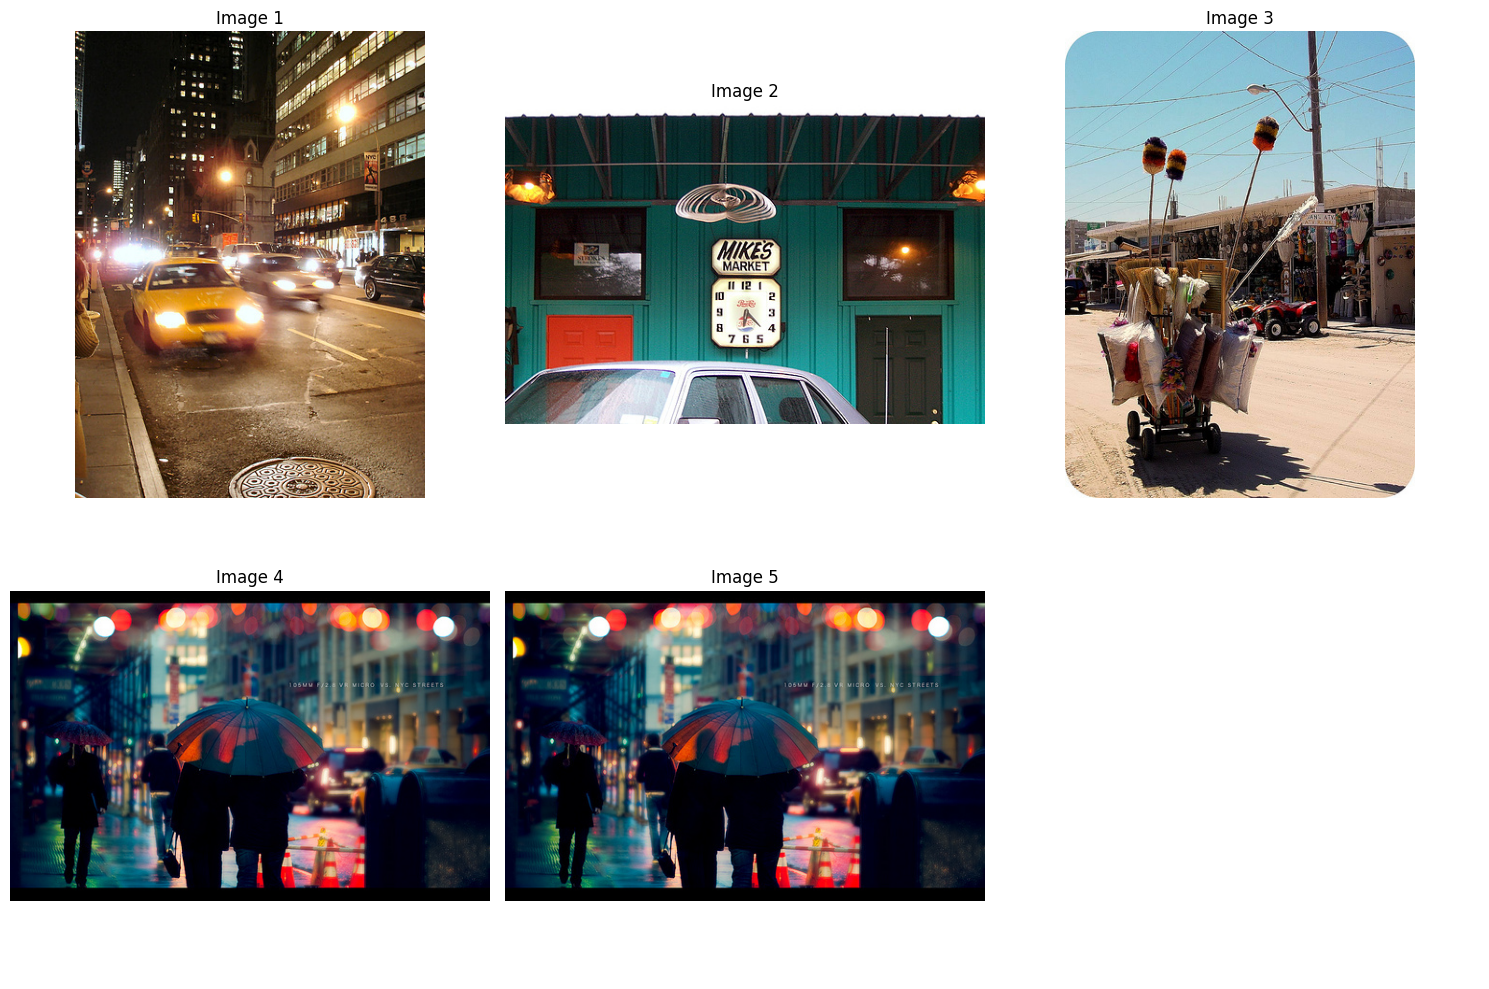

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

# Function to display images
def display_images(image_paths):
    num_images = len(image_paths)
    if num_images == 0:
        print("No images to display.")
        return

    # Define grid size for display
    cols = 3  # Number of columns in the grid
    rows = (num_images + cols - 1) // cols  # Calculate rows based on the number of images

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, img_path in enumerate(image_paths):
        try:
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')  # Hide axes for better visualization
            axes[i].set_title(f"Image {i + 1}")
        except Exception as e:
            print(f"Error displaying image {img_path}: {e}")
            axes[i].axis('off')  # If error, hide the subplot

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# # List of retrieved images
# retrieved_images = [
# "/content/images/ILSVRC2012_val_00015783.JPEG",
# "/content/images/n02965783_7063.JPEG",
# "/content/images/n01855032_3374.JPEG",
# "/content/images/n03216828_37252.JPEG",
# "/content/images/n02965783_7063.JPEG"
# ]

retrieved_images = image_paths



# Display the retrieved images
display_images(retrieved_images)


# Now ,video generation process

In [1]:
import torch
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video

pipeline = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipeline.enable_model_cpu_offload()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# List of input image paths
image_paths = [
    "/content/extracted_frames/n02906734_23830.JPEG",
    "/content/extracted_frames/n02930766_2373.JPEG"
#     "/content/extracted_frames/n01855032_3374.JPEG",
#     "/content/extracted_frames/n03216828_37252.JPEG",
#     "/content/extracted_frames/n02965783_7063.JPEG"
]

# Set up parameters
generator = torch.manual_seed(42)
final_frames = []

# Process each image
for image_path in image_paths:
    # Load and resize the image
    image = load_image(image_path)
    image = image.resize((1024, 576))

    # Generate video frames from the image
    frames = pipeline(image, decode_chunk_size=8, generator=generator).frames[0]

    # Append generated frames to the final frames list
    final_frames.extend(frames)

# Export the final concatenated video
export_to_video(final_frames, "final_generated_video.mp4", fps=10)

print("Final video saved as 'final_generated_video.mp4'")

  0%|          | 0/25 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.76 GiB. GPU 0 has a total capacity of 14.75 GiB of which 813.06 MiB is free. Process 318900 has 13.95 GiB memory in use. Of the allocated memory 12.57 GiB is allocated by PyTorch, and 1.25 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [9]:
len(final_frames)

125

In [11]:
# Export the final concatenated video
export_to_video(final_frames, "final_generated_video.mp4", fps=10)

'final_generated_video.mp4'